Some rough fits to the sky surface brightness to use as inputs in the simulated spectra

In [70]:
import os
import h5py 
import numpy as np 
from scipy.optimize import curve_fit
import astropy.units as u

from feasibgs import util as UT

In [8]:
import desimodel.io
import desisim.simexp

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [5]:
# ccd wavelength limit 
params = desimodel.io.load_desiparams() 
wavemin = params['ccd']['b']['wavemin']
wavemax = params['ccd']['z']['wavemax']
print('%f < lambda < %f' % (wavemin, wavemax))

3533.000000 < lambda < 9913.000000


Read in the bright sky spectrum produced from BOSS by Parker

In [6]:
dark_sky = np.loadtxt(UT.dat_dir()+'sky/spec-sky.dat', unpack=True, skiprows=2, usecols=[0,1])

f = UT.dat_dir()+'sky/moon_sky_spectrum.hdf5'
assert os.path.isfile(f)
f_hdf5 = h5py.File(f, 'r')
ws, ss = [], [] 
for i in range(4): 
    ws.append(f_hdf5['sky'+str(i)+'/wave'].value)
    ss.append(f_hdf5['sky'+str(i)+'/sky'].value)
    
bright_sky_flux0= [10.*ws[2], ss[2]]
bright_sky_flux1 = [10.*ws[3], ss[3]]

Divide the sky flux by fiber area in $arcsec^2$. For BOSS the fiber area is $\pi\,\,arcsec^2$

In [12]:
bright_sky_sbright0 = [bright_sky_flux0[0], bright_sky_flux0[1]/np.pi]
bright_sky_sbright1 = [bright_sky_flux1[0], bright_sky_flux1[1]/np.pi]

Now read in the dark sky surface brightness from `spec-sky.dat`

In [9]:
waves = dark_sky[0][(dark_sky[0] > wavemin) & (dark_sky[1] < wavemax)] * u.Angstrom
config = desisim.simexp._specsim_config_for_wave((waves).to('Angstrom').value, specsim_config_file='desi')

In [11]:
atm_config = config.atmosphere
surface_brightness_dict = config.load_table(atm_config.sky, 'surface_brightness', as_dict=True)

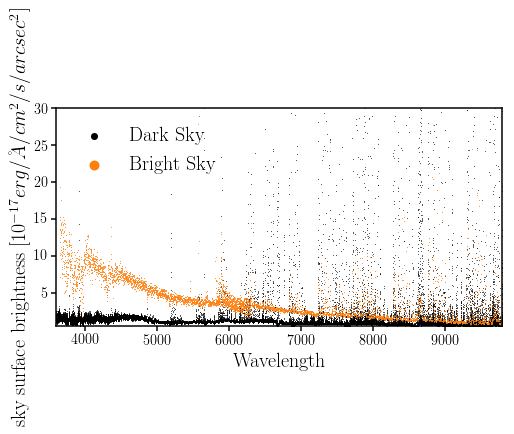

In [26]:
fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(111)
sub.scatter(config.wavelength, surface_brightness_dict['dark'], c='k', lw=0, s=0.5, label='Dark Sky')
sub.scatter(bright_sky_sbright0[0], bright_sky_sbright0[1], c='C1', lw=0, s=1., label='Bright Sky')
sub.scatter(bright_sky_sbright1[0], bright_sky_sbright1[1], c='C1', lw=0, s=1.)
sub.set_xlabel('Wavelength', fontsize=20)
sub.set_xlim([3600., 9800.])
sub.set_ylabel('sky surface brightness [$10^{-17} erg/\AA/cm^2/s/arcsec^2$]', fontsize=20)
#sub.set_yscale("log")
sub.set_ylim([0.5, 3e1])
sub.legend(loc='upper left', markerscale=10, prop={'size':20})

In [38]:
def smooth(ww, sb): 
    ''' smooth out the sufrace brightness somehow...
    '''
    wavebin = np.linspace(wavemin, wavemax, 10)
    sb_med = np.zeros(len(wavebin)-1)
    for i in range(len(wavebin)-1): 
        inwbin = ((wavebin[i] < ww) & (ww < wavebin[i+1]) & np.isfinite(sb))
        if np.sum(inwbin) > 0.: 
            sb_med[i] = np.median(sb[inwbin])
    return 0.5*(wavebin[1:]+wavebin[:-1]), sb_med

In [46]:
surface_brightness_dict['dark'].value

array([1.6251 , 1.9038 , 2.0132 , ..., 0.81443, 0.80715, 0.75561])

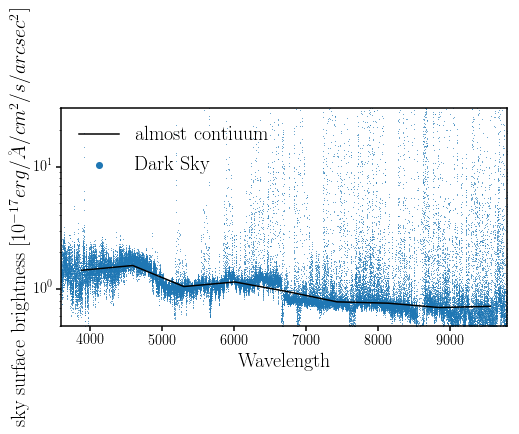

In [52]:
fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(111)
sub.scatter(config.wavelength, surface_brightness_dict['dark'], c='C0', lw=0, s=0.5, label='Dark Sky')
w_smooth_dark, sb_smooth_dark = smooth(config.wavelength.value, surface_brightness_dict['dark'].value)
sub.plot(w_smooth_dark, sb_smooth_dark, c='k', label='almost contiuum')
sub.set_xlabel('Wavelength', fontsize=20)
sub.set_xlim([3600., 9800.])
sub.set_ylabel('sky surface brightness [$10^{-17} erg/\AA/cm^2/s/arcsec^2$]', fontsize=20)
sub.set_yscale("log")
sub.set_ylim([0.5, 3e1])
sub.legend(loc='upper left', markerscale=10, prop={'size':20})

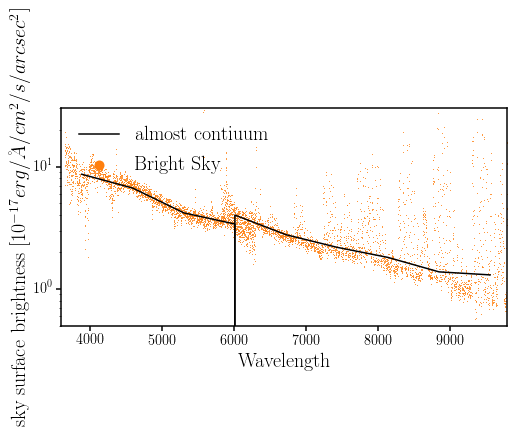

In [54]:
fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(111)
sub.scatter(bright_sky_sbright0[0], bright_sky_sbright0[1], c='C1', lw=0, s=1., label='Bright Sky')
w_smooth_bright0, sb_smooth_bright0 = smooth(bright_sky_sbright0[0], bright_sky_sbright0[1])
sub.plot(w_smooth_bright0, sb_smooth_bright0, c='k', label='almost contiuum')
sub.scatter(bright_sky_sbright1[0], bright_sky_sbright1[1], c='C1', lw=0, s=1.)
w_smooth_bright1, sb_smooth_bright1 = smooth(bright_sky_sbright1[0], bright_sky_sbright1[1])
sub.plot(w_smooth_bright1, sb_smooth_bright1, c='k')
sub.set_xlabel('Wavelength', fontsize=20)
sub.set_xlim([3600., 9800.])
sub.set_ylabel('sky surface brightness [$10^{-17} erg/\AA/cm^2/s/arcsec^2$]', fontsize=20)
sub.set_yscale("log")
sub.set_ylim([0.5, 3e1])
sub.legend(loc='upper left', markerscale=10, prop={'size':20})

combine the two smoothed bright sky surface brightnesses

In [59]:
sb_smooth_bright = np.zeros(len(w_smooth_bright0))
for i in range(len(w_smooth_bright0)): 
    if (sb_smooth_bright0[i] == 0) or (sb_smooth_bright1[i] == 0): 
        sb_smooth_bright[i] = np.max([sb_smooth_bright0[i], sb_smooth_bright1[i]])
    else: 
        sb_smooth_bright[i] = np.mean([sb_smooth_bright0[i], sb_smooth_bright1[i]])

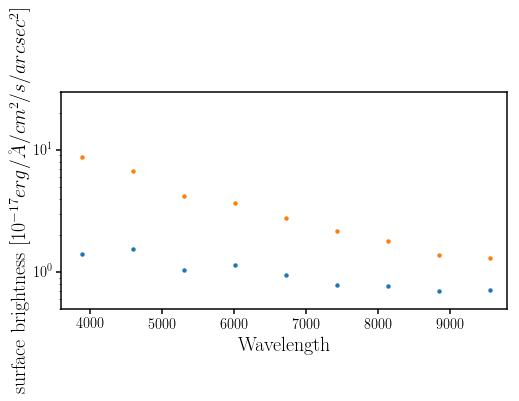

In [62]:
fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(111)
sub.scatter(w_smooth_dark, sb_smooth_dark, c='C0', lw=0, s=20.)#, label='Bright Sky')
sub.scatter(w_smooth_bright0, sb_smooth_bright, c='C1', lw=0, s=20.)
sub.set_xlabel('Wavelength', fontsize=20)
sub.set_xlim([3600., 9800.])
sub.set_ylabel('surface brightness [$10^{-17} erg/\AA/cm^2/s/arcsec^2$]', fontsize=20)
sub.set_yscale("log")
sub.set_ylim([0.5, 3e1])
sub.legend(loc='upper left', markerscale=10, prop={'size':20})

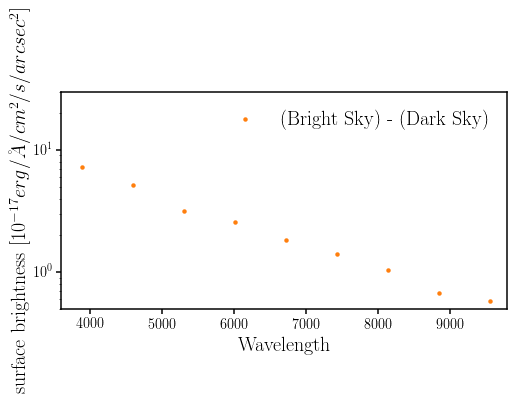

In [67]:
fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(111)
sub.scatter(w_smooth_dark, sb_smooth_bright - sb_smooth_dark, c='C1', lw=0, s=20., 
            label='(Bright Sky) - (Dark Sky)')
sub.set_xlabel('Wavelength', fontsize=20)
sub.set_xlim([3600., 9800.])
sub.set_ylabel('surface brightness [$10^{-17} erg/\AA/cm^2/s/arcsec^2$]', fontsize=20)
sub.set_yscale("log")
sub.set_ylim([0.5, 3e1])
sub.legend(loc='upper right', prop={'size':20})

In [68]:
def SBright_resid(x, a, b, c): 
    return np.exp(b * (x-a) + c)

In [75]:
theta, _ = curve_fit(SBright_resid, w_smooth_dark/1000., sb_smooth_bright - sb_smooth_dark, p0=(10, -0.2, 1.))

In [78]:
print theta

[ 5.07057687 -0.48793746  1.38885749]


best-fit of the residual surface brightness is

$$r(\lambda) = e^{-0.000488 (\lambda - 5071.) + 1.388}$$

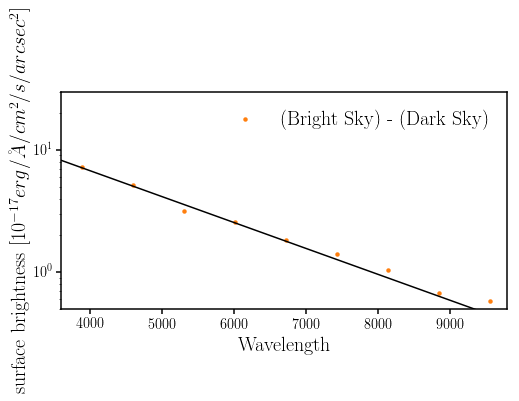

In [77]:
fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(111)
sub.scatter(w_smooth_dark, sb_smooth_bright - sb_smooth_dark, c='C1', lw=0, s=20., 
            label='(Bright Sky) - (Dark Sky)')
xarr = np.linspace(3, 12, 100)
sub.plot(1000.*xarr, SBright_resid(xarr, *theta), c='k')
sub.set_xlabel('Wavelength', fontsize=20)
sub.set_xlim([3600., 9800.])
sub.set_ylabel('surface brightness [$10^{-17} erg/\AA/cm^2/s/arcsec^2$]', fontsize=20)
sub.set_yscale("log")
sub.set_ylim([0.5, 3e1])
sub.legend(loc='upper right', prop={'size':20})

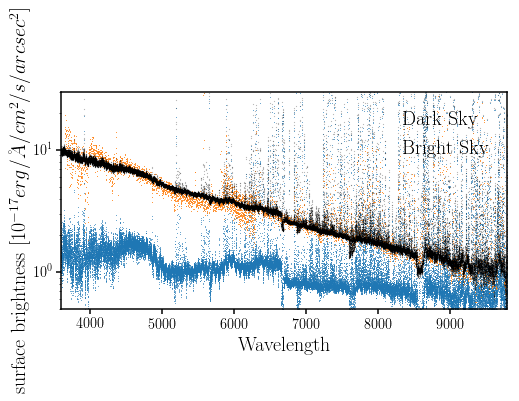

In [82]:
fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(111)
sub.scatter(config.wavelength, surface_brightness_dict['dark'], c='C0', lw=0, s=0.5, label='Dark Sky')
sub.scatter(bright_sky_sbright0[0], bright_sky_sbright0[1], c='C1', lw=0, s=1., label='Bright Sky')
sub.scatter(bright_sky_sbright1[0], bright_sky_sbright1[1], c='C1', lw=0, s=1.)
sub.scatter(config.wavelength, 
            surface_brightness_dict['dark'].value+SBright_resid(config.wavelength.value/1000., *theta), c='k', s=0.01)
#xarr = np.linspace(3, 12, 100)
#sub.plot(1000.*xarr, SBright_resid(xarr, *theta), c='k')
sub.set_xlabel('Wavelength', fontsize=20)
sub.set_xlim([3600., 9800.])
sub.set_ylabel('surface brightness [$10^{-17} erg/\AA/cm^2/s/arcsec^2$]', fontsize=20)
sub.set_yscale("log")
sub.set_ylim([0.5, 3e1])
sub.legend(loc='upper right', prop={'size':20})

looks pretty good.